# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [4-Seam RHP](#4-Seam-RHP)
    - [4-Seam LHP](#4-Seam-LHP)
    - [Cutter RHP](#Cutter-RHP)
    - [Cutter LHP](#Cutter-LHP)
    - [Sinker RHP](#Sinker-RHP)
    - [Sinker LHP](#Sinker-LHP)
    - [Slider RHP](#Slider-RHP)
    - [Slider LHP](#Slider-LHP)
    - [Curveball RHP](#Curveball-RHP)
    - [Curveball LHP](#Curveball-LHP)
    - [Changeup RHP](#Changeup-RHP)
    - [Changeup LHP](#Changeup-LHP)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705434, 63)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,0.0,1.0,0.158,61,4,9,0,5,0,5,0,0,0,0,2,36.0,1,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.11
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,2,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,0.00
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,1,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,0.00
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,1,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.00
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,0.0,1.0,0.090,60,2,9,0,5,0,5,0,0,0,0,1,36.0,1,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.18


# Cleaning / EDA

### Features

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo',
                 'pfx_x', 'pfx_z', 'release_extension', 'arm_angle',
                 'rv']]

In [4]:
fastball = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]
breaking_ball = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]
offspeed = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

In [5]:
ff_r.groupby(['player_name', 'pitch_type'], as_index = False)['rv'].sum()

,player_name,pitch_type,rv
0,"Abbott, Cory",FF,7.91
1,"Abreu, Albert",FF,0.24
2,"Abreu, Bryan",FF,2.54
3,"Acevedo, Domingo",FF,3.15
4,"Adam, Jason",FF,4.66
...,...,...,...
588,"Zimmer, Kyle",FF,9.61
589,"Zimmermann, Jordan",FF,-0.24
590,"Zuber, Tyler",FF,7.63
591,"de Geus, Brett",FF,-0.27


# Random Forest Regression Model

# 4-Seam RHP

In [6]:
print('Baseline RHP 4-Seam RunValue Accuracy Score:', round(ff_r.rv.mean(), 2))

Baseline RHP 4-Seam RunValue Accuracy Score: 0.01


In [7]:
features_ff_r = ff_r.select_dtypes([np.number])
X = features_ff_r.drop(columns = ['rv'])
y = features_ff_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_ff_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ff_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.066
Test RMSE: 0.261
Test MAE: 0.129 

R2 Score: 0.62
RMSE: 0.154
MAE: 0.068


### RHP 4-Seam Actual & Predicted Run Values

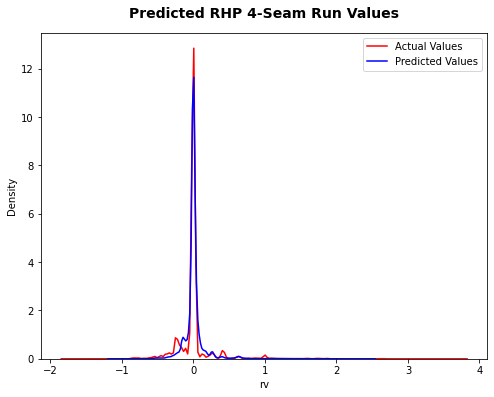

In [8]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP 4-Seam RV Table

In [9]:
ff_r['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_r['pitch_type']]
ff_r['xRV'] = pred
grouped_ff_r = ff_r.groupby(['player_name', 'pitch_type'],
                            as_index=False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 
                                            'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ff_r['RV/100'] = round(((grouped_ff_r['rv'] / grouped_ff_r['n_pitches']) * 100), 2)
grouped_ff_r['xRV/100'] = round(((grouped_ff_r['xRV'] / grouped_ff_r['n_pitches']) * 100), 2)

ff_r_group = pd.merge(ff_r, grouped_ff_r, how = 'left', on = ['player_name'])
drop_cols = ['n_pitches_x', 'pitch_type_y', 'velo_y', 'pfx_x_y', 'pfx_z_y', 'arm_angle_y']
ff_r_group.drop(columns = drop_cols, inplace = True)
col_dict = {
    'pitch_type_x': 'pitch_type', 'n_pitches_y': 'n_pitches', 'velo_x': 'velo',
    'pfx_x_x': 'HB', 'pfx_z_x': 'VB', 'release_extension_x': 'rel_extension',
    'arm_angle_x': 'arm_angle', 'spin_rate_x': 'spin_rate', 
    'release_pos_x_x': 'release_pos_x', 'release_pos_z_x': 'release_pos_z', 
    'rv_y': 'RV', 'xRV_y': 'xRV'
}
ff_r_group.rename(columns = col_dict, inplace = True)

ff_r_rv_table = ff_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ff_r_rv_table = ff_r_rv_table.round(1)
print(ff_r_rv_table.shape) 
ff_r_rv_table.head()

(593, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,6.2,43.3,7.9,3.8,6.2,3.0
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,6.4,40.8,0.2,0.2,-1.4,-1.3
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,6.3,28.7,2.5,0.8,4.5,1.4
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,5.8,31.0,3.2,3.6,0.9,1.0
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,6.7,34.5,4.7,3.7,2.9,2.3


### RHP 4-Seam xRV by HB & VB

RHP 4-Seam Avg xRunValue: 0.01


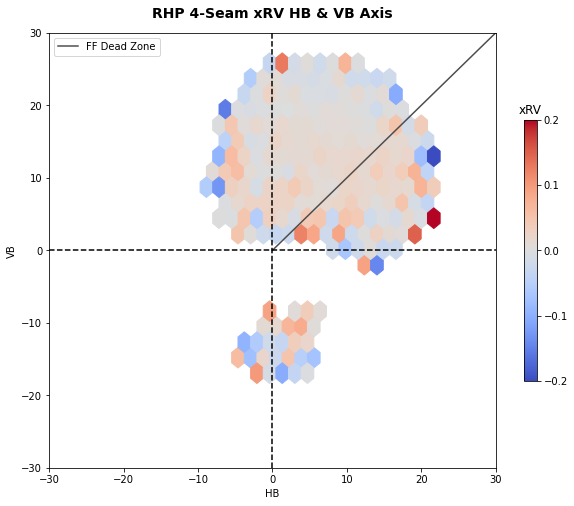

In [10]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_r['pfx_x'], ff_r['pfx_z'], C = ff_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP 4-Seam xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP 4-Seam Avg xRunValue:', round(ff_r.xRV.mean(), 2))

# 4-Seam LHP

In [11]:
print('Baseline LHP 4-Seam RunValue Accuracy Score:', round(ff_l.rv.mean(), 2))

Baseline LHP 4-Seam RunValue Accuracy Score: 0.01


In [12]:
features_ff_l = ff_l.select_dtypes([np.number])
X = features_ff_l.drop(columns = ['rv'])
y = features_ff_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_ff_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ff_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.073
Test RMSE: 0.257
Test MAE: 0.128 

R2 Score: 0.622
RMSE: 0.152
MAE: 0.068


### LHP 4-Seam Actual & Predicted Run Values

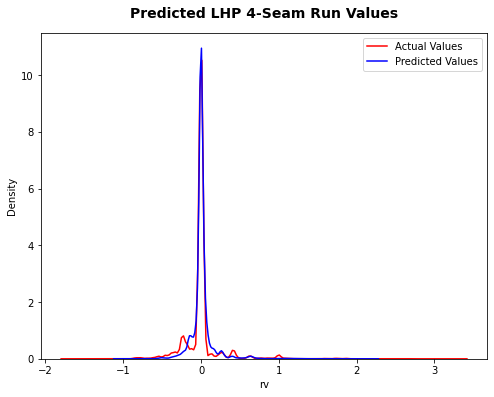

In [13]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam RV Table

In [14]:
ff_l['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_l['pitch_type']]
ff_l['xRV'] = pred
grouped_ff_l = ff_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ff_l['RV/100'] = round(((grouped_ff_l['rv'] / grouped_ff_l['n_pitches']) * 100), 2)
grouped_ff_l['xRV/100'] = round(((grouped_ff_l['xRV'] / grouped_ff_l['n_pitches']) * 100), 2)

ff_l_group = pd.merge(ff_l, grouped_ff_l, how = 'left', on = ['player_name'])
ff_l_group.drop(columns = drop_cols, inplace = True)
ff_l_group.rename(columns = col_dict, inplace = True)
ff_l_rv_table = ff_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ff_l_rv_table = ff_l_rv_table.round(1)
print(ff_l_rv_table.shape)
ff_l_rv_table.head()

(210, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,FF,18.0,91.7,-5.3,16.2,5.9,11.3,3.0,16.7,1.9,10.7
1,"Aguilar, Miguel",L,FF,62.0,91.4,-4.8,15.7,6.0,28.6,-0.4,-0.6,1.3,2.1
2,"Akin, Keegan",L,FF,1009.0,92.0,-10.7,18.1,5.9,77.3,-1.9,-0.2,-4.4,-0.4
3,"Albers, Andrew",L,FF,116.0,88.4,-7.5,18.8,6.2,63.7,4.0,3.4,3.7,3.2
4,"Alexander, Tyler",L,FF,244.0,90.5,-7.1,16.4,6.3,67.5,-3.7,-1.5,0.2,0.1


### LHP 4-Seam xRV by HB & VB

LHP 4-Seam Avg xRunValue: 0.01


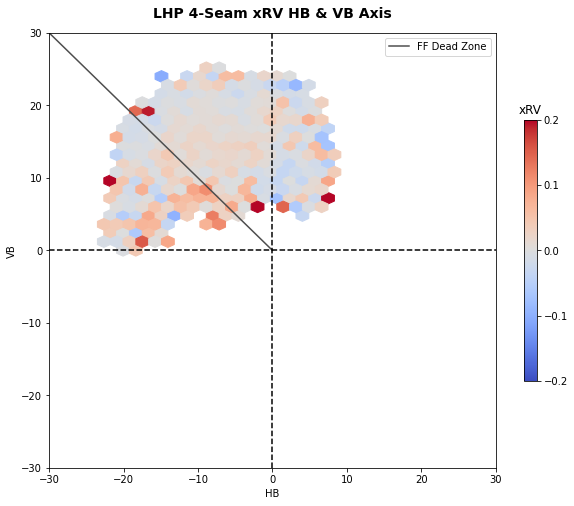

In [15]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_l['pfx_x'], ff_l['pfx_z'], C = ff_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
plt.plot([0, -30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP 4-Seam xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP 4-Seam Avg xRunValue:', round(ff_l.xRV.mean(), 2))

# Cutter RHP

In [16]:
print('Baseline RHP Cutter RunValue Accuracy Score:', round(fc_r.rv.mean(), 2))

Baseline RHP Cutter RunValue Accuracy Score: 0.0


In [17]:
features_fc_r = fc_r.select_dtypes([np.number])
X = features_fc_r.drop(columns = ['rv'])
y = features_fc_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_fc_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_fc_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.08
Test RMSE: 0.263
Test MAE: 0.137 

R2 Score: 0.63
RMSE: 0.158
MAE: 0.072


### RHP Cutter Actual & Predicted Values

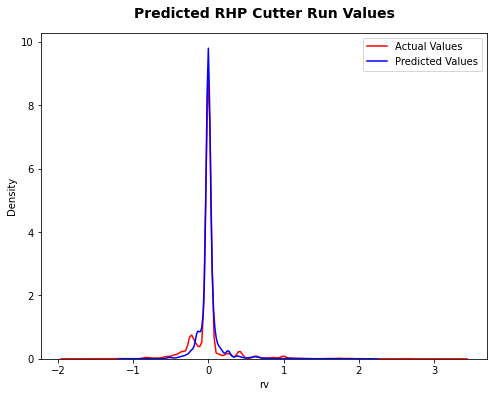

In [18]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Cutter RV Table

In [19]:
fc_r['n_pitches'] = [1 if x == 'FC' else 0 for x in fc_r['pitch_type']]
fc_r['xRV'] = pred
grouped_fc_r = fc_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_fc_r['RV/100'] = round(((grouped_fc_r['rv'] / grouped_fc_r['n_pitches']) * 100), 2)
grouped_fc_r['xRV/100'] = round(((grouped_fc_r['xRV'] / grouped_fc_r['n_pitches']) * 100), 2)

fc_r_group = pd.merge(fc_r, grouped_fc_r, how = 'left', on = ['player_name'])
fc_r_group.drop(columns = drop_cols, inplace = True)
fc_r_group.rename(columns = col_dict, inplace = True)
fc_r_rv_table = fc_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB','rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
fc_r_rv_table = fc_r_rv_table.round(1)
print(fc_r_rv_table.shape)
fc_r_rv_table.head()

(165, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Alcántara, Sergio",R,FC,1.0,85.9,7.2,15.5,5.2,34.9,0.0,0.0,-0.0,-1.2
1,"Alzolay, Adbert",R,FC,129.0,90.2,-3.5,6.9,6.3,32.7,2.3,1.8,3.1,2.4
2,"Anderson, Chase",R,FC,191.0,86.6,-3.9,8.1,5.8,17.7,2.3,1.2,6.1,3.2
3,"Anderson, Tanner",R,FC,7.0,87.8,0.5,7.6,5.8,40.0,0.0,0.3,0.3,4.5
4,"Andriese, Matt",R,FC,44.0,85.8,-2.5,3.0,5.8,38.8,2.8,6.4,3.8,8.6


### RHP Cutter xRV by HB & VB

RHP Cutter Avg xRunValue: 0.01


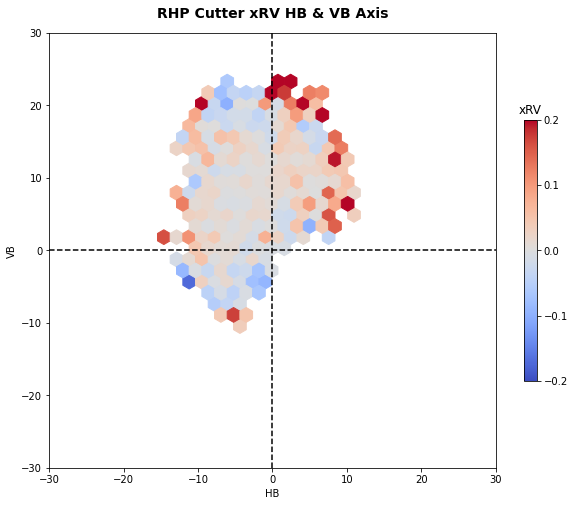

In [20]:
plt.figure(figsize = (10, 8))

plt.hexbin(fc_r['pfx_x'], fc_r['pfx_z'], C = fc_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Cutter Avg xRunValue:', round(fc_r.xRV.mean(), 2))

## Cutter LHP

In [21]:
print('Baseline LHP Cutter RunValue Accuracy Score:', round(fc_l.rv.mean(), 2))

Baseline LHP Cutter RunValue Accuracy Score: 0.0


In [22]:
features_fc_l = fc_l.select_dtypes([np.number])
X = features_fc_l.drop(columns = ['rv'])
y = features_fc_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_fc_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_fc_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.065
Test RMSE: 0.275
Test MAE: 0.14 

R2 Score: 0.611
RMSE: 0.163
MAE: 0.074


### LHP Cutter Actual & Predicted Values

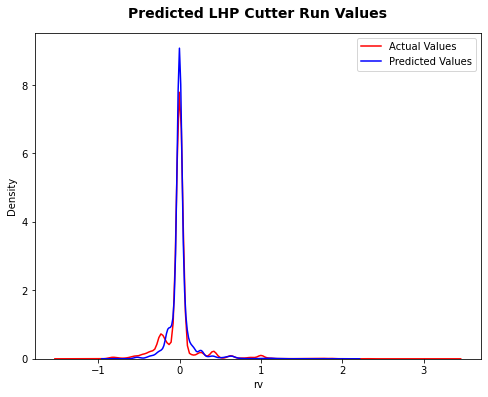

In [23]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Cutter RV Table

In [24]:
fc_l['n_pitches'] = [1 if x == 'FC' else 0 for x in fc_l['pitch_type']]
fc_l['xRV'] = pred
grouped_fc_l = fc_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_fc_l['RV/100'] = round(((grouped_fc_l['rv'] / grouped_fc_l['n_pitches']) * 100), 2)
grouped_fc_l['xRV/100'] = round(((grouped_fc_l['xRV'] / grouped_fc_l['n_pitches']) * 100), 2)

fc_l_group = pd.merge(fc_l, grouped_fc_l, how = 'left', on = ['player_name'])
fc_l_group.drop(columns = drop_cols, inplace = True)
fc_l_group.rename(columns = col_dict, inplace = True)
fc_l_rv_table = fc_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
fc_l_rv_table = fc_l_rv_table.round(1)
print(fc_l_rv_table.shape)
fc_l_rv_table.head()

(61, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,FC,16.0,82.6,3.4,2.7,5.9,32.2,0.2,1.2,0.6,3.8
1,"Alexander, Tyler",L,FC,581.0,86.2,3.7,8.5,6.2,69.6,-1.8,-0.3,-2.7,-0.5
2,"Allard, Kolby",L,FC,507.0,86.3,2.4,6.0,6.1,76.1,12.4,2.4,10.1,2.0
3,"Alvarado, José",L,FC,170.0,94.1,1.3,5.1,6.7,25.5,-9.1,-5.3,-8.0,-4.7
4,"Anderson, Brett",L,FC,117.0,85.7,0.7,9.5,5.9,41.0,1.0,0.8,2.0,1.7


### LHP Cutter xRV by HB & VB

LHP Cutter Avg xRunValue: 0.01


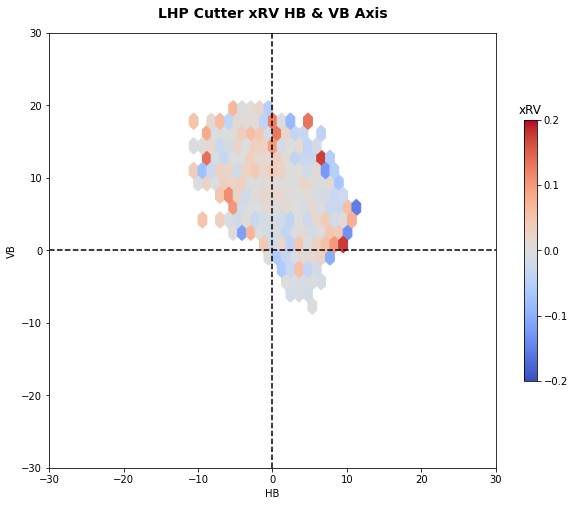

In [25]:
plt.figure(figsize = (10, 8))

plt.hexbin(fc_l['pfx_x'], fc_l['pfx_z'], C = fc_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Cutter Avg xRunValue:', round(fc_l.xRV.mean(), 2))

## Sinker RHP

In [26]:
print('Baseline RHP Sinker RunValue Accuracy Score:', round(si_r.rv.mean(), 2))

Baseline RHP Sinker RunValue Accuracy Score: 0.01


In [27]:
features_si_r = si_r.select_dtypes([np.number])
X = features_si_r.drop(columns = ['rv'])
y = features_si_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_si_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_si_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_si_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.065
Test RMSE: 0.276
Test MAE: 0.143 

R2 Score: 0.619
RMSE: 0.164
MAE: 0.076


### RHP Sinker Actual & Predicted Values

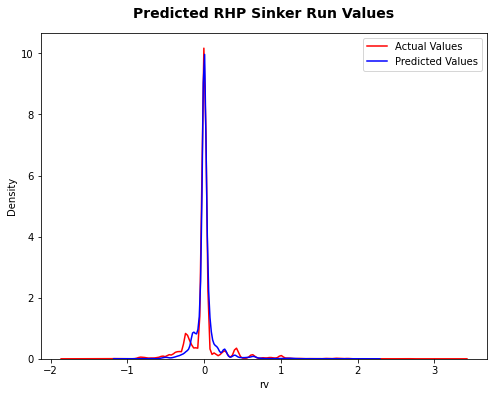

In [28]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Sinker RV Table

In [29]:
si_r['n_pitches'] = [1 if x == 'SI' else 0 for x in si_r['pitch_type']]
si_r['xRV'] = pred
grouped_si_r = si_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_si_r['RV/100'] = round(((grouped_si_r['rv'] / grouped_si_r['n_pitches']) * 100), 2)
grouped_si_r['xRV/100'] = round(((grouped_si_r['xRV'] / grouped_si_r['n_pitches']) * 100), 2)

si_r_group = pd.merge(si_r, grouped_si_r, how = 'left', on = ['player_name'])
si_r_group.drop(columns = drop_cols, inplace = True)
si_r_group.rename(columns = col_dict, inplace = True)
si_r_rv_table = si_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
si_r_rv_table = si_r_rv_table.round(1)
print(si_r_rv_table.shape)
si_r_rv_table.head()

(357, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abreu, Albert",R,SI,212.0,98.0,15.3,13.3,6.5,41.0,3.2,1.5,4.8,2.2
1,"Abreu, Bryan",R,SI,2.0,96.0,14.2,14.9,6.4,33.5,0.0,0.0,-0.0,-1.1
2,"Adon, Joan",R,SI,1.0,97.2,14.8,15.5,6.3,42.8,0.0,0.0,0.0,2.4
3,"Alaniz, R.J.",R,SI,37.0,92.8,16.9,9.9,5.8,39.0,0.8,2.2,0.3,0.7
4,"Alcala, Jorge",R,SI,52.0,97.2,16.5,10.3,5.7,38.6,1.4,2.8,0.9,1.7


### RHP Sinker xRV by HB & VB

RHP Sinker Avg xRunValue: 0.01


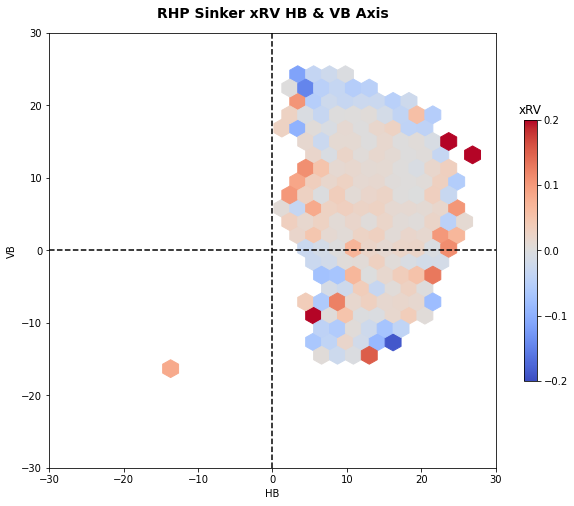

In [30]:
plt.figure(figsize = (10, 8))

plt.hexbin(si_r['pfx_x'], si_r['pfx_z'], C = si_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Sinker Avg xRunValue:', round(si_r.xRV.mean(), 2))

## Sinker LHP

In [31]:
print('Baseline LHP Sinker RunValue Accuracy Score:', round(si_l.rv.mean(), 2))

Baseline LHP Sinker RunValue Accuracy Score: 0.01


In [32]:
features_si_l = si_l.select_dtypes([np.number])
X = features_si_l.drop(columns = ['rv'])
y = features_si_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_si_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_si_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_si_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.084
Test RMSE: 0.263
Test MAE: 0.138 

R2 Score: 0.627
RMSE: 0.157
MAE: 0.074


### LHP Sinker Actual & Predicted Values

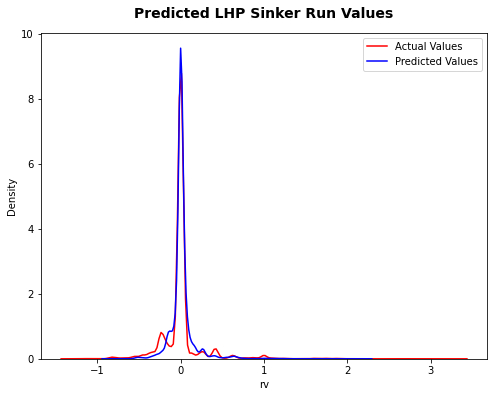

In [33]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Sinker RV Table

In [34]:
si_l['n_pitches'] = [1 if x == 'SI' else 0 for x in si_l['pitch_type']]
si_l['xRV'] = pred
grouped_si_l = si_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z',
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_si_l['RV/100'] = round(((grouped_si_l['rv'] / grouped_si_l['n_pitches']) * 100), 2)
grouped_si_l['xRV/100'] = round(((grouped_si_l['xRV'] / grouped_si_l['n_pitches']) * 100), 2)

si_l_group = pd.merge(si_l, grouped_si_l, how = 'left', on = ['player_name'])
si_l_group.drop(columns = drop_cols, inplace = True)
si_l_group.rename(columns = col_dict, inplace = True)
si_l_rv_table = si_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
si_l_rv_table = si_l_rv_table.round(1)
print(si_l_rv_table.shape)
si_l_rv_table.head()

(152, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,SI,141.0,92.4,-13.2,12.9,5.8,13.9,-1.4,-1.0,1.4,1.0
1,"Albers, Andrew",L,SI,117.0,88.3,-13.3,15.1,6.1,51.6,1.3,1.1,2.9,2.5
2,"Alexander, Scott",L,SI,192.0,92.2,-14.1,4.9,6.1,59.4,1.0,0.5,2.3,1.2
3,"Alexander, Tyler",L,SI,337.0,90.2,-14.5,13.2,6.2,65.8,4.5,1.3,8.1,2.4
4,"Allard, Kolby",L,SI,8.0,92.5,-13.3,16.4,6.2,74.3,-0.1,-1.4,-0.2,-2.0


### LHP Sinker xRV by HB & VB

LHP Sinker Avg xRunValue: 0.01


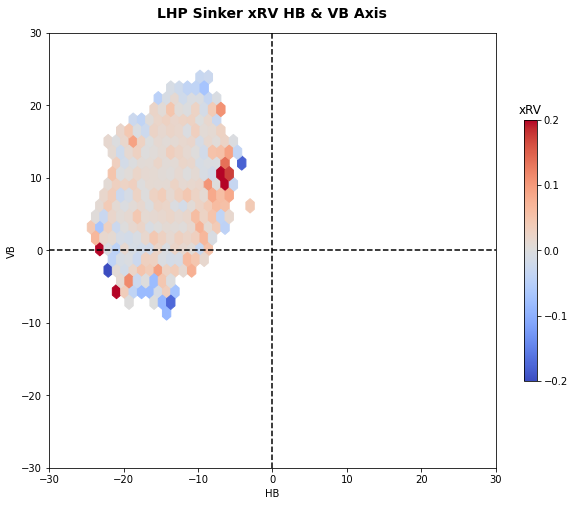

In [35]:
plt.figure(figsize = (10, 8))

plt.hexbin(si_l['pfx_x'], si_l['pfx_z'], C = si_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Sinker Avg xRunValue:', round(si_l.xRV.mean(), 2))

## Slider RHP

In [36]:
print('Baseline RHP Slider RunValue Accuracy Score:', round(sl_r.rv.mean(), 2))

Baseline RHP Slider RunValue Accuracy Score: -0.01


In [37]:
features_sl_r = sl_r.select_dtypes([np.number])
X = features_sl_r.drop(columns = ['rv'])
y = features_sl_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_sl_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_sl_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.061
Test RMSE: 0.266
Test MAE: 0.132 

R2 Score: 0.62
RMSE: 0.158
MAE: 0.07


### RHP Slider Actual & Predicted Values

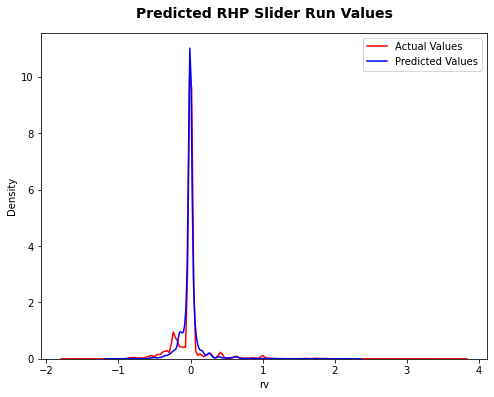

In [38]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Slider RV Table

In [39]:
sl_r['n_pitches'] = [1 if x == 'SL' else 0 for x in sl_r['pitch_type']]
sl_r['xRV'] = pred
grouped_sl_r = sl_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_sl_r['RV/100'] = round(((grouped_sl_r['rv'] / grouped_sl_r['n_pitches']) * 100), 2)
grouped_sl_r['xRV/100'] = round(((grouped_sl_r['xRV'] / grouped_sl_r['n_pitches']) * 100), 2)

sl_r_group = pd.merge(sl_r, grouped_sl_r, how = 'left', on = ['player_name'])
sl_r_group.drop(columns = drop_cols, inplace = True)
sl_r_group.rename(columns = col_dict, inplace = True)
sl_r_rv_table = sl_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
sl_r_rv_table = sl_r_rv_table.round(1)
print(sl_r_rv_table.shape)
sl_r_rv_table.head()

(513, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,SL,63.0,87.7,6.6,3.5,6.0,42.7,2.0,3.2,3.8,6.0
1,"Abreu, Albert",R,SL,224.0,87.3,-2.8,3.5,6.3,41.5,-3.0,-1.3,-1.4,-0.6
2,"Abreu, Bryan",R,SL,256.0,88.9,-3.7,-2.2,6.3,35.1,5.8,2.3,4.7,1.8
3,"Acevedo, Domingo",R,SL,49.0,85.1,5.6,7.3,5.7,35.3,-3.5,-7.1,-2.5,-5.1
4,"Adam, Jason",R,SL,39.0,82.4,-6.7,-6.2,6.5,31.9,-1.6,-4.2,-0.4,-0.9


### RHP Slider xRV by HB & VB

RHP Slider Avg xRunValue: -0.01


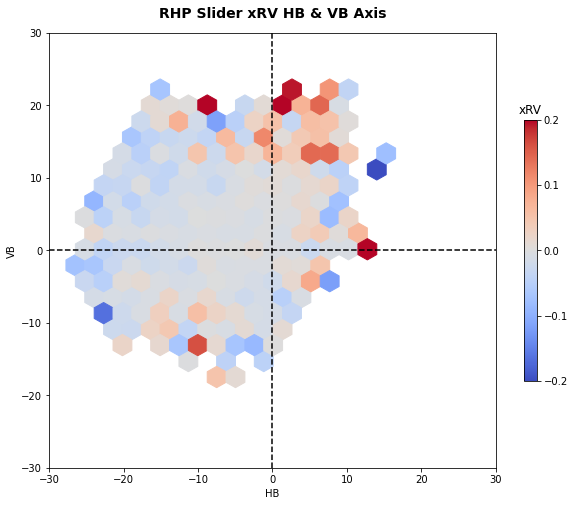

In [40]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_r['pfx_x'], sl_r['pfx_z'], C = sl_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Slider Avg xRunValue:', round(sl_r.xRV.mean(), 2))

## Slider LHP

In [41]:
print('Baseline LHP Slider RunValue Accuracy Score:', round(sl_l.rv.mean(), 2))

Baseline LHP Slider RunValue Accuracy Score: -0.01


In [42]:
features_sl_l = sl_l.select_dtypes([np.number])
X = features_sl_l.drop(columns = ['rv'])
y = features_sl_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_sl_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_sl_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.074
Test RMSE: 0.273
Test MAE: 0.136 

R2 Score: 0.611
RMSE: 0.161
MAE: 0.072


### LHP Slider Actual & Predicted Values

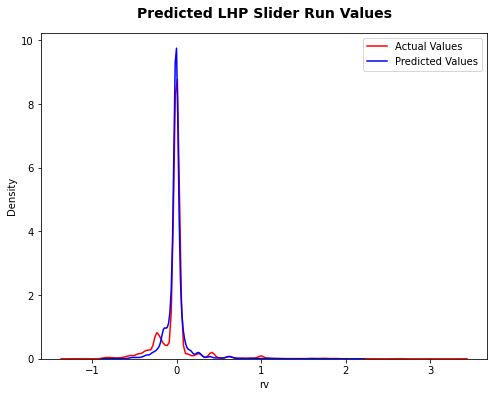

In [43]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Slider RV Table

In [44]:
sl_l['n_pitches'] = [1 if x == 'SL' else 0 for x in sl_l['pitch_type']]
sl_l['xRV'] = pred
grouped_sl_l = sl_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_sl_l['RV/100'] = round(((grouped_sl_l['rv'] / grouped_sl_l['n_pitches']) * 100), 2)
grouped_sl_l['xRV/100'] = round(((grouped_sl_l['xRV'] / grouped_sl_l['n_pitches']) * 100), 2)

sl_l_group = pd.merge(sl_l, grouped_sl_l, how = 'left', on = ['player_name'])
sl_l_group.drop(columns = drop_cols, inplace = True)
sl_l_group.rename(columns = col_dict, inplace = True)
sl_l_rv_table = sl_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
sl_l_rv_table = sl_l_rv_table.round(1)
print(sl_l_rv_table.shape)
sl_l_rv_table.head()

(175, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Aguilar, Miguel",L,SL,20.0,85.9,5.3,5.2,6.0,34.3,1.9,9.4,1.4,6.8
1,"Akin, Keegan",L,SL,344.0,84.2,4.5,3.2,5.9,84.5,9.3,2.7,7.1,2.1
2,"Albers, Andrew",L,SL,54.0,78.1,2.6,-1.3,6.0,41.4,0.8,1.6,2.8,5.2
3,"Alexander, Scott",L,SL,45.0,84.3,3.9,-4.2,6.0,56.1,-1.3,-2.8,-0.8,-1.8
4,"Alexander, Tyler",L,SL,173.0,82.2,5.3,0.9,6.3,63.3,-6.8,-4.0,-2.8,-1.6


### LHP Slider xRV by HB & VB

LHP Slider Avg xRunValue: -0.01


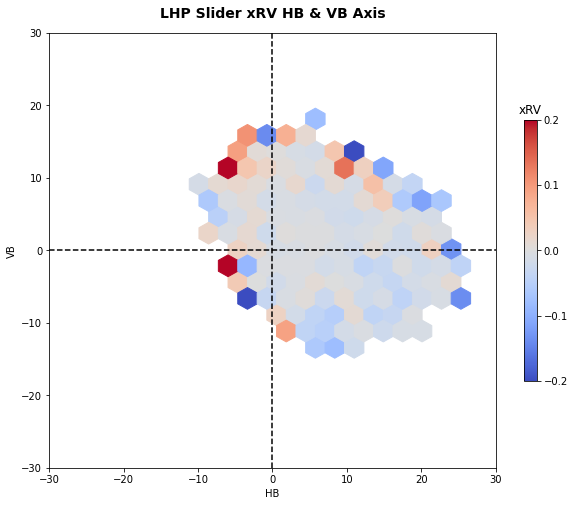

In [45]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_l['pfx_x'], sl_l['pfx_z'], C = sl_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 15)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Slider Avg xRunValue:', round(sl_l.xRV.mean(), 2))

## Curveball RHP

In [46]:
print('Baseline RHP Curveball RunValue Accuracy Score:', round(cu_r.rv.mean(), 2))

Baseline RHP Curveball RunValue Accuracy Score: -0.01


In [47]:
features_cu_r = cu_r.select_dtypes([np.number])
X = features_cu_r.drop(columns = ['rv'])
y = features_cu_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_cu_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_cu_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.086
Test RMSE: 0.24
MAE: 0.119 

R2 Score: 0.62
Test RMSE: 0.142
MAE: 0.062


### RHP Curveball Actual & Predicted Run Values

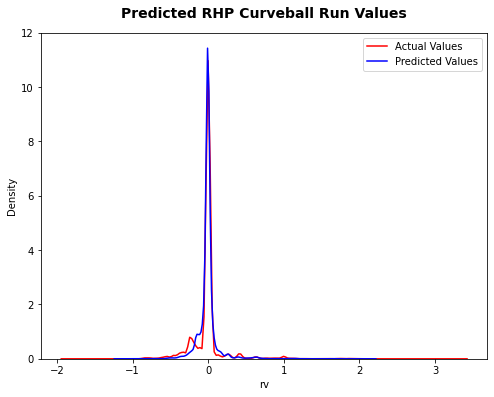

In [48]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Curveball RV Table

In [49]:
cu_r['n_pitches'] = [1 if x == 'CU' else 0 for x in cu_r['pitch_type']]
cu_r['xRV'] = pred
grouped_cu_r = cu_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z',
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_cu_r['RV/100'] = round(((grouped_cu_r['rv'] / grouped_cu_r['n_pitches']) * 100), 2)
grouped_cu_r['xRV/100'] = round(((grouped_cu_r['xRV'] / grouped_cu_r['n_pitches']) * 100), 2)

cu_r_group = pd.merge(cu_r, grouped_cu_r, how = 'left', on = ['player_name'])
cu_r_group.drop(columns = drop_cols, inplace = True)
cu_r_group.rename(columns = col_dict, inplace = True)
cu_r_rv_table = cu_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
cu_r_rv_table = cu_r_rv_table.round(1)
print(cu_r_rv_table.shape)
cu_r_rv_table.head()

(335, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CU,58.0,84.1,-5.6,-9.9,5.9,42.1,-3.7,-6.4,-2.3,-4.0
1,"Abreu, Albert",R,CU,1.0,81.0,-9.5,-13.9,6.5,40.3,0.0,0.0,0.0,1.6
2,"Abreu, Bryan",R,CU,121.0,86.5,-7.5,-10.0,6.1,28.5,2.9,2.4,-1.0,-0.8
3,"Alcantara, Sandy",R,CU,79.0,83.7,-3.8,-3.8,5.9,37.5,2.5,3.1,0.4,0.5
4,"Alexy, A.J.",R,CU,34.0,76.2,-9.6,-17.2,6.5,20.4,-0.1,-0.3,-0.1,-0.3


### RHP Curveball xRV by HB & VB

RHP Curveball Avg xRunValue: -0.01


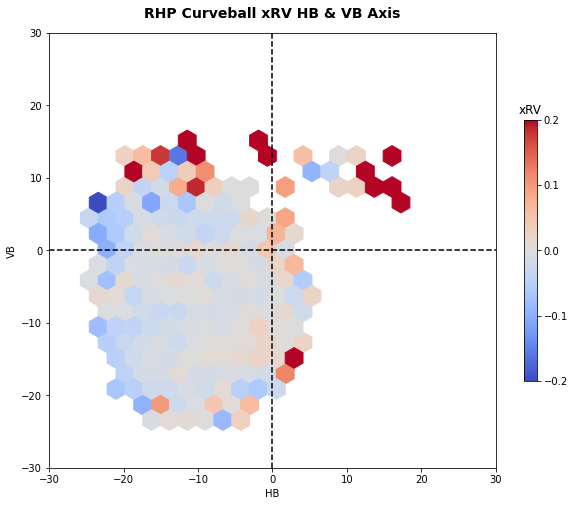

In [50]:
plt.figure(figsize = (10, 8))

plt.hexbin(cu_r['pfx_x'], cu_r['pfx_z'], C = cu_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Curveball Avg xRunValue:', round(cu_r.xRV.mean(), 2))

## Curveball LHP

In [51]:
print('Baseline LHP Curveball RunValue Accuracy Score:', round(cu_l.rv.mean(), 2))

Baseline LHP Curveball RunValue Accuracy Score: -0.01


In [52]:
features_cu_l = cu_l.select_dtypes([np.number])
X = features_cu_l.drop(columns = ['rv'])
y = features_cu_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_cu_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_cu_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.092
Test RMSE: 0.236
Test MAE: 0.12 

R2 Score: 0.632
RMSE: 0.141
MAE: 0.064


### LHP Curveball Actual & Predicted Run Values

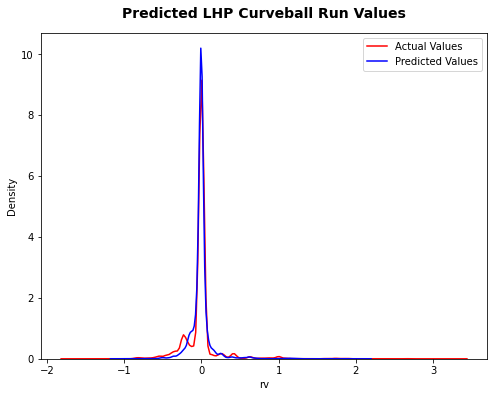

In [53]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Curveball RV Table

In [54]:
cu_l['n_pitches'] = [1 if x == 'CU' else 0 for x in cu_l['pitch_type']]
cu_l['xRV'] = pred
grouped_cu_l = cu_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z',
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_cu_l['RV/100'] = round(((grouped_cu_l['rv'] / grouped_cu_l['n_pitches']) * 100), 2)
grouped_cu_l['xRV/100'] = round(((grouped_cu_l['xRV'] / grouped_cu_l['n_pitches']) * 100), 2)

cu_l_group = pd.merge(cu_l, grouped_cu_l, how = 'left', on = ['player_name'])
cu_l_group.drop(columns = drop_cols, inplace = True)
cu_l_group.rename(columns = col_dict, inplace = True)
cu_l_rv_table = cu_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension', 
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
cu_l_rv_table = cu_l_rv_table.round(1)
print(cu_l_rv_table.shape)
cu_l_rv_table.head()

(133, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Aguilar, Miguel",L,CU,19.0,80.4,14.2,5.7,5.9,40.1,-2.3,-12.2,-1.2,-6.2
1,"Akin, Keegan",L,CU,69.0,76.5,6.0,-4.1,5.9,83.8,1.1,1.6,0.1,0.1
2,"Albers, Andrew",L,CU,25.0,68.8,8.3,-9.7,5.9,55.6,0.7,2.9,-0.0,-0.1
3,"Allard, Kolby",L,CU,227.0,75.9,4.5,-8.9,5.8,69.3,0.4,0.2,-0.4,-0.2
4,"Allen, Logan",L,CU,78.0,76.8,9.5,-13.5,5.9,61.0,0.4,0.6,-0.6,-0.7


### LHP Curveball xRV by HB & VB

LHP Curveball Avg xRunValue: -0.01


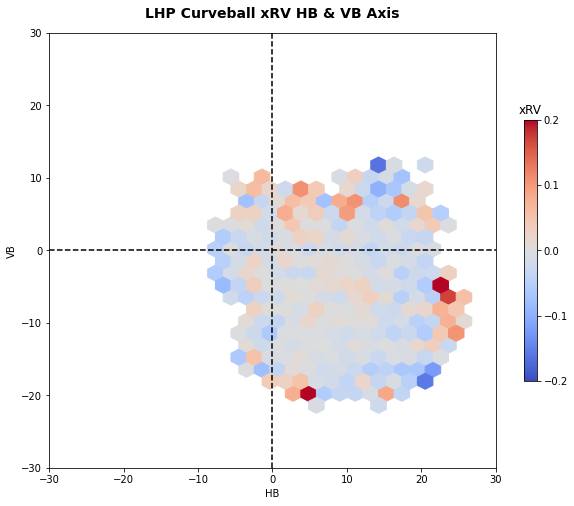

In [55]:
plt.figure(figsize = (10, 8))

plt.hexbin(cu_l['pfx_x'], cu_l['pfx_z'], C = cu_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Curveball Avg xRunValue:', round(cu_l.xRV.mean(), 2))

## Changeup RHP

In [56]:
print('Baseline RHP Changeup RunValue Accuracy Score:', round(ch_r.rv.mean(), 2))

Baseline RHP Changeup RunValue Accuracy Score: -0.0


In [57]:
features_ch_r = ch_r.select_dtypes([np.number])
X = features_ch_r.drop(columns = ['rv'])
y = features_ch_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_ch_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ch_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.055
Test RMSE: 0.269
Test MAE: 0.136 

R2 Score: 0.617
RMSE: 0.159
MAE: 0.072


### RHP Changeup Actual & Predicted Values

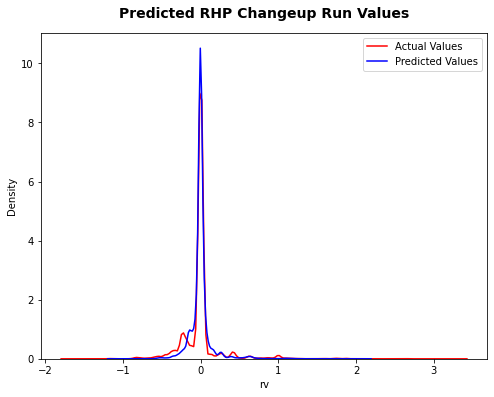

In [58]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Changeup RV Table

In [59]:
ch_r['n_pitches'] = [1 if x == 'CH' else 0 for x in ch_r['pitch_type']]
ch_r['xRV'] = pred
grouped_ch_r = ch_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z',
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ch_r['RV/100'] = round(((grouped_ch_r['rv'] / grouped_ch_r['n_pitches']) * 100), 2)
grouped_ch_r['xRV/100'] = round(((grouped_ch_r['xRV'] / grouped_ch_r['n_pitches']) * 100), 2)

ch_r_group = pd.merge(ch_r, grouped_ch_r, how = 'left', on = ['player_name'])
ch_r_group.drop(columns = drop_cols, inplace = True)
ch_r_group.rename(columns = col_dict, inplace = True)
ch_r_rv_table = ch_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension',
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ch_r_rv_table = ch_r_rv_table.round(1)
print(ch_r_rv_table.shape)
ch_r_rv_table.head()

(472, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CH,23.0,87.0,13.9,12.3,6.1,40.3,-1.0,-4.2,-0.4,-1.9
1,"Abreu, Albert",R,CH,102.0,88.2,16.8,8.6,6.5,38.6,2.5,2.4,1.8,1.7
2,"Acevedo, Domingo",R,CH,37.0,86.0,16.9,8.7,6.0,27.8,-1.5,-4.1,-0.3,-0.7
3,"Adam, Jason",R,CH,22.0,87.2,15.8,2.7,6.6,33.1,0.4,1.6,-0.2,-0.7
4,"Adon, Joan",R,CH,6.0,87.1,16.8,9.3,6.2,43.6,0.0,0.0,0.1,1.0


### RHP Changeup xRV by HB & VB

RHP Changeup Avg xRunValue: -0.0


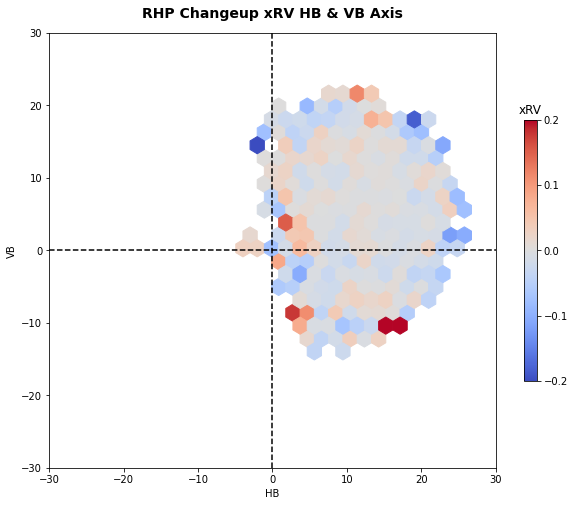

In [60]:
plt.figure(figsize = (10, 8))

plt.hexbin(ch_r['pfx_x'], ch_r['pfx_z'], C = ch_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Changeup Avg xRunValue:', round(ch_r.xRV.mean(), 2))

## Changeup LHP

In [61]:
print('Baseline LHP Changeup RunValue Accuracy Score:', round(ch_l.rv.mean(), 2))

Baseline LHP Changeup RunValue Accuracy Score: -0.0


In [62]:
features_ch_l = ch_l.select_dtypes([np.number])
X = features_ch_l.drop(columns = ['rv'])
y = features_ch_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, 
                           n_jobs = -1, 
                           random_state = 1).fit(X_train, y_train)

pred_ch_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ch_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.074
Test RMSE: 0.27
Test MAE: 0.144 

R2 Score: 0.622
RMSE: 0.161
MAE: 0.075


### LHP Changeup Actual & Predicted Values

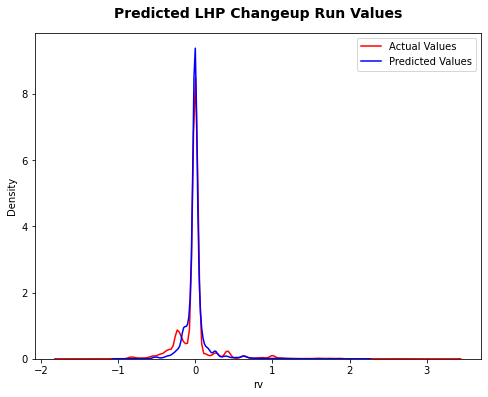

In [63]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Changeup RV Table

In [64]:
ch_l['n_pitches'] = [1 if x == 'CH' else 0 for x in ch_l['pitch_type']]
ch_l['xRV'] = pred
grouped_ch_l = ch_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z',
                                              'release_extension', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ch_l['RV/100'] = round(((grouped_ch_l['rv'] / grouped_ch_l['n_pitches']) * 100), 2)
grouped_ch_l['xRV/100'] = round(((grouped_ch_l['xRV'] / grouped_ch_l['n_pitches']) * 100), 2)

ch_l_group = pd.merge(ch_l, grouped_ch_l, how = 'left', on = ['player_name'])
ch_l_group.drop(columns = drop_cols, inplace = True)
ch_l_group.rename(columns = col_dict, inplace = True)
ch_l_rv_table = ch_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'rel_extension', 
                                                     'arm_angle', 'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ch_l_rv_table = ch_l_rv_table.round(1)
print(ch_l_rv_table.shape)
ch_l_rv_table.head()

(180, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,rel_extension,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,CH,46.0,75.1,-10.7,14.2,5.9,17.7,-2.4,-5.2,-2.1,-4.5
1,"Aguilar, Miguel",L,CH,3.0,85.8,-14.9,8.9,6.1,31.5,0.0,0.0,0.0,0.4
2,"Akin, Keegan",L,CH,344.0,81.9,-15.3,8.4,6.0,83.2,7.2,2.1,3.3,1.0
3,"Albers, Andrew",L,CH,53.0,80.0,-12.7,7.7,6.1,70.2,-1.2,-2.3,-0.7,-1.3
4,"Alexander, Scott",L,CH,22.0,86.2,-13.6,4.5,6.1,57.0,0.3,1.3,0.2,1.0


### LHP Changeup xRV by HB & VB

LHP Changeup Avg xRunValue: 0.0


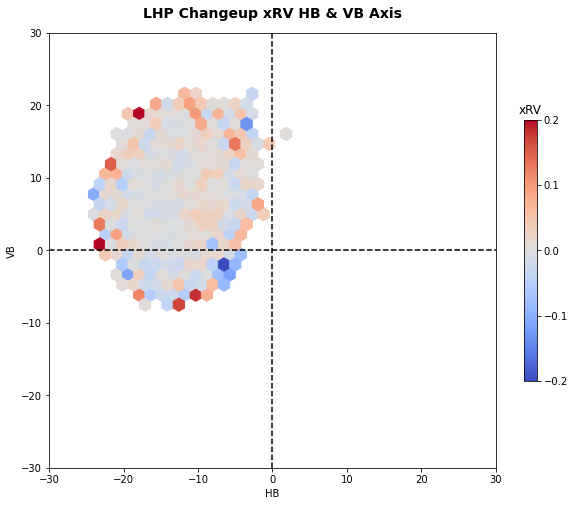

In [65]:
plt.figure(figsize = (10, 8))

plt.hexbin(ch_l['pfx_x'], ch_l['pfx_z'], C = ch_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Changeup Avg xRunValue:', round(ch_l.xRV.mean(), 2))

### Save RV tables to CSV

In [66]:
xrv_predictions = pd.concat([ff_r, ff_l, fc_r, fc_l, si_r, si_l, sl_r, sl_l, cu_r, cu_l, ch_r, ch_l], 
                        ignore_index = True)
xrv_predictions.to_csv('../data/xrv-pitches.csv')

rv_pitches_table = pd.concat([ff_r_rv_table, ff_l_rv_table, fc_r_rv_table, fc_l_rv_table, si_r_rv_table, 
                              si_l_rv_table, sl_r_rv_table, sl_l_rv_table, cu_r_rv_table, cu_l_rv_table, 
                              ch_r_rv_table, ch_l_rv_table], 
                             ignore_index = True)
rv_pitches_table.to_csv('../data/pitches-rv-table.csv')